# Part II - Bike Sharing Explanation
## by Austin Jex

## Investigation Overview

## Dataset Overview and Executive Summary

>The relationship between member age and ride duration is negligible (no relationship). 

>Start stations near the center of a city tend to have higher ride count and lower ride duration, compared to start stations on the outskirt of the city. 


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import math

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
bike = pd.read_csv('final_bike_df.csv')
stations = pd.read_csv('final_stations_df.csv')

## (Visualization 1)

> This scatterplot with line of best fit visualizes that the relationship between member age and ride duration is approximately zero (no correlary relationship). I have chosen to plot the line of best fit on this graph to illustrate this lack of a correlary relationship. Without plotting a line of best fit, the graph can be hard to interpret, given how there are so many data points that the graph is mostly a big blue blob. The line of best fit demonstrates the lack of relationship between the variables. I've also added a label showing that the correlation coefficient = 0.02 (also demonstrating no relationship).

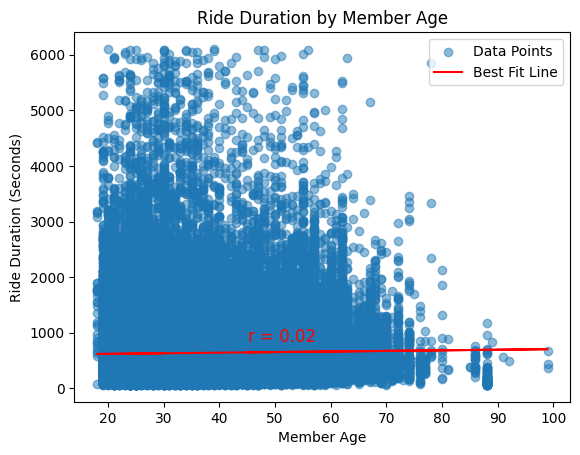

In [41]:
#Remove NA values so that I can plot a line of best fit to my scatterplot
bike_clean = bike.dropna(subset=['Age', 'duration_sec'])

#Scatterplot of age and ride duration
yaxis = bike_clean['duration_sec']
xaxis = bike_clean['Age']

# Compute the line of best fit
slope, intercept = np.polyfit(xaxis, yaxis, 1)  # 1st-degree polynomial (linear fit)
best_fit_line = slope * xaxis + intercept  # Compute y-values

# Calculate the correlation coefficient (r)
correlation_matrix = np.corrcoef(xaxis, yaxis)
r = correlation_matrix[0, 1]  # Extract the correlation coefficient

# Plot the scatterplot
plt.scatter(xaxis, yaxis, label="Data Points", alpha=0.5)
plt.plot(xaxis, best_fit_line, color="red", label="Best Fit Line")  # Add best-fit line

# Add the correlation coefficient to the plot
r_text = f"r = {r:.2f}"
plt.text(0.35, 0.20, r_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='red')

# Labels and title
plt.title("Ride Duration by Member Age")
plt.xlabel("Member Age")
plt.ylabel("Ride Duration (Seconds)")
plt.legend() 
plt.show()

## (Visualization 2)
The following vizualization shows data points for each start station in the San Francisco area. I have narrowed the scope of the visualization to San Francisco only (excluding the San Jose and Oakland stations) for the following reasons: limiting the map to a smaller area makes for less dragging on the interactive map, and San Francisco has far more rides than the other two cities (bigger sample size). This map visualization depicts the ride count of each start station using the size dimension (bigger circles for stations with more rides), and it depicts average ride duration using the color dimension (orange for shorter average ride durations, blue for longer average ride durations). The visualization demonstrates that start stations closer to the center of San Francisco tend to have more rides, and shorter ride durations.

In [48]:
stations.head()

,start_station_name,duration_sec,start_station_latitude,start_station_longitude,ride_count,normalized_size
0,10th Ave at E 15th St,872.508772,37.792714,-122.248780,57,0.219681
1,10th St at Fallon St,702.376437,37.797673,-122.262997,348,1.341213
2,10th St at University Ave,816.678947,37.869060,-122.293400,190,0.732271
3,11th St at Bryant St,561.312802,37.770030,-122.411726,828,3.191161
4,11th St at Natoma St,588.643519,37.773507,-122.416040,864,3.329908


In [3]:
#Firstly, I need to make a DataFrame where station longitude is restricted to those less than -122.32 (this will leave only San Francisco stations remaining).
sf_stations = stations[(stations['start_station_longitude'] < -122.32)]

In [6]:
#Adding a relative size variable based on ride count
sf_stations["normalized_size"] = sf_stations["ride_count"] / sf_stations["ride_count"].max() * 20

In [7]:
sf_stations.head(3)

,start_station_name,duration_sec,start_station_latitude,start_station_longitude,ride_count,normalized_size
3,11th St at Bryant St,561.312802,37.770030,-122.411726,828,4.254882
4,11th St at Natoma St,588.643519,37.773507,-122.416040,864,4.439877
8,14th St at Mission St,570.565972,37.768265,-122.420110,576,2.959918


In [8]:
#Plotting stations by average ride duration (color dimension) and relative ride count (size dimension)
# Normalize 'duration_sec' to a color scale (340 to 2000 seconds → orange to blue)
norm = mcolors.Normalize(vmin=340, vmax=2000)
colormap = cm.ScalarMappable(norm=norm, cmap="coolwarm_r")  

# Create a Folium map centered on the mean location
m = folium.Map(
    location=[sf_stations["start_station_latitude"].mean(), 
              sf_stations["start_station_longitude"].mean()], 
    zoom_start=10,
    width=800,  
    height=800,
    tiles="CartoDB positron"
)

# Add circle markers, colored by 'duration_sec'
for _, row in sf_stations.iterrows():
    duration = row["duration_sec"]
    color = mcolors.to_hex(colormap.to_rgba(duration))  # Convert color to hex
    size = (row["normalized_size"])
    folium.CircleMarker(
        location=[row["start_station_latitude"], row["start_station_longitude"]],
        radius=size, 
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
    ).add_to(m)

# Add a legend
colormap = folium.LinearColormap(["orange", "blue"], vmin=340, vmax=2000, caption="Ride Duration (seconds)")
m.add_child(colormap)

# Show the map
m

## (Visualization 3 & 4)

>The above visuaization shows a very interesting map of start stations ride durations and ride counts. I'd like to find a way to visualize a quantified version of the relationships between these variables and the distance from the city center.

>In order to quantify these relationships (and find correlation coefficents to substantiate the relationships I observe in the previous visualization), I will find the center of the cluster of stations in this dataset (again, just looking at San Francisco), and I will calculate a "distance from city center" variable for each station.

>To be more efficient in my coding, I am going to create a function that produces a scatterplot of the two different relationships of interest

In [56]:
#Find the average latitude and longitude of San Francisco stations
print(sf_stations['start_station_latitude'].sum()/sf_stations['start_station_latitude'].count())
print(sf_stations['start_station_longitude'].sum()/sf_stations['start_station_longitude'].count())

37.77192928212394
-122.41244736840427


In [9]:
# Define the city center (lat, long) as average station latitude and average station longitude
city_center_lat = 37.77192928212394
city_center_long = -122.41244736840427

In [10]:
#This adds a calculated column of distance from city center, using station latitude, station longitude, lat/long to mile conversion equations, and the Pythagorean theorem.
sf_stations['distance_from_city_center'] = ((69 * abs(city_center_lat - sf_stations['start_station_latitude']))**2 + 
                                           (69.17 * abs(city_center_long - sf_stations['start_station_longitude']) * 
                                           sf_stations['start_station_latitude'].apply(math.cos))**2).apply(math.sqrt)


In [17]:
#Renaming some columns for more clarity
sf_stations = sf_stations.rename(columns={
    'duration_sec': 'Average_Ride_Duration_(Seconds)',
    'ride_count': 'Ride_Count'})

In [18]:
sf_stations.head()

,start_station_name,Average_Ride_Duration_(Seconds),start_station_latitude,start_station_longitude,Ride_Count,normalized_size,distance_from_city_center
3,11th St at Bryant St,561.312802,37.770030,-122.411726,828,4.254882,0.140201
4,11th St at Natoma St,588.643519,37.773507,-122.416040,864,4.439877,0.270682
8,14th St at Mission St,570.565972,37.768265,-122.420110,576,2.959918,0.586122
9,15th St at Potrero Ave,558.057234,37.767079,-122.407359,629,3.232271,0.485132
10,16th St Depot,632.500000,37.766349,-122.396292,2,0.010277,1.179578


In [19]:
#To avoid repetitive code, I will make a function which can be used to plot a scatterplot of the relationship of interest
xaxis = sf_stations['distance_from_city_center']

def scatterplot_sf(yaxis):
    plt.title(yaxis.name.replace("_", " ") + " by Station Distance From City Center")
    plt.xlabel("Station Distance From City Center")
    plt.ylabel(yaxis.name.replace("_", " "))
    slope, intercept = np.polyfit(xaxis, yaxis, 1)  # 1st-degree polynomial (linear fit)
    best_fit_line = slope * xaxis + intercept  # Compute y-values
    correlation_matrix = np.corrcoef(xaxis, yaxis)
    r = correlation_matrix[0, 1]
    plt.scatter(xaxis, yaxis, label="Data Points", alpha=0.5)
    plt.plot(xaxis, best_fit_line, color="red", label="Best Fit Line")
    r_text = f"r = {r:.2f}"
    plt.text(0.35, 0.40, r_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='red')
    plt.legend()
    plt.show()

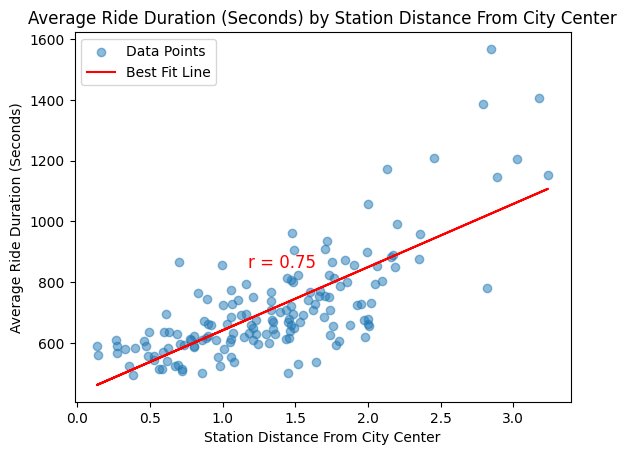

In [20]:
#Call the scatterplot function with y axis = average ride duration
scatterplot_sf(sf_stations['Average_Ride_Duration_(Seconds)'])

This scatterplot demonstrates that the correlation between ride duration and station distance to city center is, in fact, a strong positive correlation. This quantitative finding substantiates the finding I had after looking at the data mapped onto the streets of San Francisco (the quantitative findings match the "eye test").

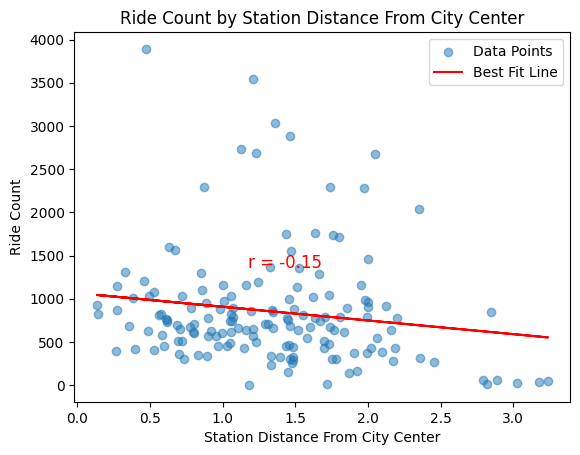

In [21]:
#Call the scatterplot function with y axis = ride count
scatterplot_sf(sf_stations['Ride_Count'])

This scatterplot visualizes the relationship between station ride count and station distance to city center. This relationship is a very weak negative correlation. The map plot seemed to suggest a much stronger negative correlation between these two variables, so this quantitative finding is a bit more surprising than the finding for the average ride duration variable. 

I suspect that these correlations are weakened slightly by the fact that San Francisco sits on the east side of a peninsula. Due to its adjacency to the bay, the east side of the cluster is much more densely populated than the west side of the station cluster. This can be seen in the ride count (circle size) on the plotly map, where there are pretty larger circles quite close to the bay. I think that if the data had come from a more land-locked city, then the edges of the station cluster would look a bit more symmetical, and thus the city center would likely be the epicenter of ride count, and ride count per station would diecrease as radius increased from epicenter. 

Whatever the case, it is really interesting to see how the "eye test" on the scatter map is substantiated somewhat by the quantitative analysis. In the case of ride duration, the correlation is strong. In the case of ride count, the correlation is weaker than the map makes it seem. 

### Submission
If you are using classroom workspace, you can choose from the following two ways of submission:

1. **Submit from the workspace**. Make sure you have removed the example project from the /home/workspace directory. You must submit the following files:
   - Part_I_notebook.ipynb
   - Part_I_notebook.html or pdf
   - Part_II_notebook.ipynb
   - Part_II_notebook.html or pdf


2. **Submit a zip file on the last page of this project lesson**. In this case, open the Jupyter terminal and run the command below to generate a ZIP file. 
```bash
zip -r my_project.zip .
```
The command abobve will ZIP every file present in your /home/workspace directory. Next, you can download the zip to your local, and follow the instructions on the last page of this project lesson.
